In [1]:
from Bio import SeqIO
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import csv
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment


In [22]:
# Pick CyCOG to process throughout notebook
CYCOG = 60001888

In [23]:
# Create directories for data inputs and outputs
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('data/0'):
    os.makedirs('data/0')
if not os.path.exists(f'data/{CYCOG}'):
    os.makedirs(f'data/{CYCOG}')

This notebook is designed to work through data taken from Berube et al., 2018. The fasta files are produced using data in their repository. You can access their data through the links provided below. I recommend moving the downloaded data files to the `data/0/` directory for ease of use in this notebook.

[File 4 of supplemental materials](https://figshare.com/articles/dataset/File_4_CyCOG_taxa/6007166?backTo=/collections/Single_cell_genomes_of_i_Prochlorococcus_i_i_Synechococcus_i_and_sympatric_microbes_from_diverse_marine_environments/4037048) from Berube et al., 2018
downloaded from 

GENOMES = data/0/cycogsgenomes.tsv

file 5 of supplemental materials from Berube et al., 2018
downloaded from https://figshare.com/articles/dataset/File_5_CyCOG_definitions/6007169?backTo=/collections/Single_cell_genomes_of_i_Prochlorococcus_i_i_Synechococcus_i_and_sympatric_microbes_from_diverse_marine_environments/4037048

CYCOG_LIST = data/0/cycogs.tsv

Some files used are provided as part of this repository. I suggest moving the files to the same directory as the last two files for ease of access.

CLADE_MAP = data/0/updated-genome-clades.csv


# Step 1: Get CyCOG Fasta File

Inputs: 
- References (reference genomes from Berube et al., 2018)
- CyCOG list (list of CyCOGs from Berube et al., 2018)

Output:
- Fasta file (sequences.faa) of all proteins associated with CyCOG of interest

Steps:
1. Get list of proteins associated with CyCOG of interest
2. Strip out protein ids

In [24]:
REFS = '../data/genomes/'
CYCOGS = 'data/0/serralysin_cycog_references.csv'
CYCOG_LIST = 'data/0/cycogs.tsv'
SEQ = "faa"

In [26]:

protein_ids = [] # empty list to store protein IDs
for line in open(CYCOG_LIST): # searches through rows in cycogs.tsv
    if f'{CYCOG}' in line: # if the line has the chosen cycog number in it:
        protein_list = line.split()[9].split(sep=',') # make a protein list using the 9th column of that row, using a comma to identify separate objects
        for protein in protein_list: # for each object in the protein list:
            _, protein_id = protein.rsplit('_', 1) # split the object using the last underscore in the name, the end of the split is identified as protein_id
            protein_ids.append(protein_id) # add the protein_id object to the protein_ids list
print('{} protein ids found'.format(len(protein_ids))) # print number of protein_ids added to list
      
output_sequences = [] # empty list to store cycog sequences
for genome in os.listdir(REFS): # for each genome file in the genomes directory:
    faa_file_path = os.path.join(REFS, genome, f'{genome}.genes.{SEQ}') # name a gene file to check for
    if os.path.isfile(faa_file_path):  # Check if the gene file exists
        fasta = SeqIO.parse(faa_file_path, "fasta") # make a variable called 'fasta' to look through
        for record in fasta: # for each entry in the fasta variable
            if record.id in protein_ids: # if the id of the entry matches an id in the protein_ids list:
                output_sequences.append(record) # add that entry to the output sequences list
print('{} protein records found'.format(len(output_sequences))) # print number of sequences added to list

# write output sequence
output_fasta = f"data/{CYCOG}/{CYCOG}.faa" # make an output file to store sequences
with open(output_fasta, "w") as output_file:
    SeqIO.write(output_sequences, output_file, "fasta") # write the output_sequences list into the output file
print('fasta file written: {}'.format(output_fasta))


351 protein ids found
351 protein records found
fasta file written: data/60001888/60001888.faa


# Step 2: Filtering Fasta Sequences

In [17]:
# Set tolerance. Tolerance will either be a specific number of amino acids or based on the standard deviation of sequence length
# tolerance = (0, 0) # first value is tolerance below the median length, second value is tolerance above the median length
tolerance = "std" # code is designed to filter out past 1 STD, but can be changed when the filtered fasta is being made


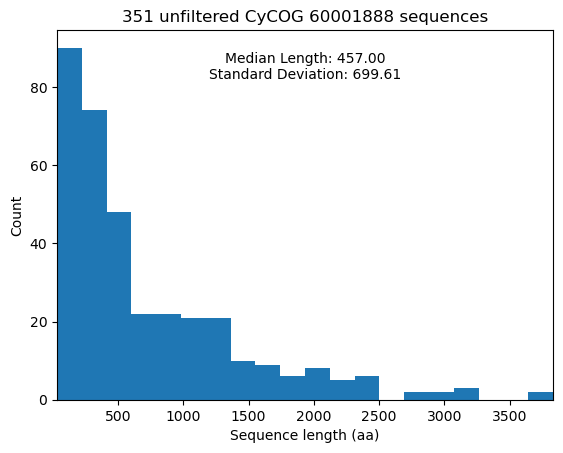

In [27]:
# make a histogram showing sequence length distributions within cycog fasta
sizes = [len(rec) for rec in SeqIO.parse(f"data/{CYCOG}/{CYCOG}.faa", "fasta")] # Parse the FASTA file and get sequence lengths

# Parse the input FASTA file and calculate median and standard deviation
sequences = []
for seq_record in SeqIO.parse(f"data/{CYCOG}/{CYCOG}.faa", "fasta"):
    sequences.append(seq_record) # add strictly sequences to empty sequences list
sequence_lengths = np.array([len(seq) for seq in sequences]) # make array w/ sequence lengths
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)
lower_lim = sequence_lengths.min() # set limits to min and max lenghts
upper_lim = sequence_lengths.max()

# Plot histogram
plt.hist(sizes, bins=20)
plt.title(f"{len(sizes)} unfiltered CyCOG {CYCOG} sequences")
plt.xlabel("Sequence length (aa)")
plt.ylabel("Count")
plt.xlim((lower_lim,upper_lim)) # apply limits to x-axis boundaries

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Save the histogram output inside the "data" directory
output_histogram_path = os.path.join(f"data/{CYCOG}/", f"{CYCOG}_hist_prefilter.png")
plt.savefig(output_histogram_path, bbox_inches='tight')

plt.show()


In [28]:
# make filtered fasta using pre-established tolerance away from median sequence length
# Define filter limits
if tolerance == "std":
    tol_low = std_dev
    tol_high = std_dev
else:
    tol_low = tolerance[0]
    tol_high = tolerance[1]

# Define output file path based on CyCOG number
output_fasta_path = os.path.join(f"data/{CYCOG}/", f"{CYCOG}_filtered.fasta")

# Filter sequences based on one standard deviation or other tolerance from the median
filtered_sequences = [seq for seq in sequences if len(seq) >= median_length - tol_low and len(seq) <= median_length + tol_high]

# Write filtered sequences to the output FASTA file
with open(output_fasta_path, "w") as output_file:
    SeqIO.write(filtered_sequences, output_file, "fasta")


print(f"Filtered fasta saved to {output_fasta_path}")

Filtered fasta saved to data/60001888/60001888_filtered.fasta


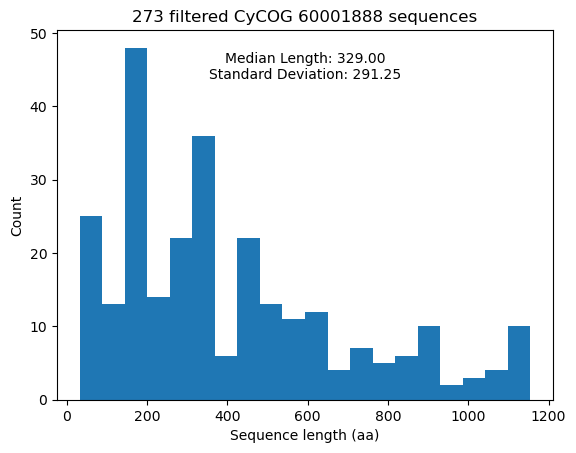

In [29]:
# make histogram using filtered fasta
# Calculate median and standard deviation
sequence_lengths = np.array([len(seq) for seq in filtered_sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)

# Plot histogram
plt.hist(sequence_lengths, bins=20)
plt.title(f"{len(sequence_lengths)} filtered CyCOG {CYCOG} sequences")
plt.xlabel("Sequence length (aa)")
plt.ylabel("Count")
# plt.xlim((lower_lim,upper_lim)) #use this line if you want to use the first plot x axis range

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Save the histogram output inside the "data" directory
output_histogram_path = os.path.join(f"data/{CYCOG}/", f"{CYCOG}_hist_filtered.png")
plt.savefig(output_histogram_path, bbox_inches='tight')

plt.show()


# Step 3: Aligning CyCOG

To infer the relationship of genetic sequences, you first need to align them as closely as you can, so that similar portions of their sequences line up with each other.

Run the following commands to align CyCOGs using the [MUSCLE multiple sequence alignment software](https://drive5.com/muscle5/):

1. Build the MUSCLE container (using singularity)
    `singularity build muscle.sif docker://quay.io/biocontainers/muscle:5.1.0--h4ac6f70_0`
1. Run MUSCLE alignment on CyCOG fasta
    `singularity exec muscle.sif muscle -align input.fasta -output alignment.afa`


Before running the muscle alignment in a remote computer, you need to import the fasta into the remote directory where the MUSCLE container is. To proceed with this notebook, the output needs to be exported from the remote computer back to the computer running this notebook. For ease of use in the notebook, I recommend placing the alignment in the "data/{CYCOG}/" directory, but it just needs to be in a reasonable place in your computer.

In [30]:
# print statement showing a specific command to use on remote computer once filtered fasta and muscle container are in the same directory:
print(f"singularity exec muscle.sif muscle -align {CYCOG}_filtered.fasta -output {CYCOG}.afa")

singularity exec muscle.sif muscle -align 60001888_filtered.fasta -output 60001888.afa


# Step 4: Trim Alignment

In [3]:
# set alignment variable equal to biopython reading of aligned fasta -- filepath may vary
alignment = AlignIO.read(f"data/{CYCOG}/{CYCOG}.afa", "fasta")


ValueError: No records found in handle

In [16]:
# define function for trimming gappy heads and tails off alignment
def slice_alignment(alignment):
    # Get the alignment length
    alignment_length = alignment.get_alignment_length()

    # Set the threshold for % non-gap characters needed for signifigance
    threshold = int(0.95 * len(alignment)) #integer represents proportion of non-gap characters, 0.95 is 95%

    # Find the first and last columns meeting the threshold, establish empty variables to be filled
    first_non_gap_col = None
    last_non_gap_col = None
    
    # trimming heads from start forward:
    for col in range(alignment_length):
        if sum(seq[col] != '-' for seq in alignment) >= threshold:
            first_non_gap_col = col
            break
    #trimming tails from end backward:
    for col in range(alignment_length - 1, -1, -1):
        if sum(seq[col] != '-' for seq in alignment) >= threshold:
            last_non_gap_col = col
            break

    # Check if both first and last columns meeting the threshold are found
    if first_non_gap_col is not None and last_non_gap_col is not None:
        # Slice out the gappy regions at the start and end of the alignment
        sliced_alignment = alignment[:, first_non_gap_col:last_non_gap_col + 1]
    else:
        sliced_alignment = None  # Return None if no columns meeting the threshold are found

    return sliced_alignment

In [8]:
# Slice off the gappy regions at the start and end of the alignment
sliced_alignment = slice_alignment(alignment)

# Check if the sliced alignment is not None
if sliced_alignment is not None:
    # Save the sliced alignment to a file in the data directory
    trim_align_path = os.path.join(f"data/{CYCOG}/", f"{CYCOG}_prepped.fasta")


    AlignIO.write(sliced_alignment, trim_align_path, "fasta")
    print(f"Sliced alignment saved to {trim_align_path}")
else:
    print("No columns meeting the 95% non-gap threshold found in the alignment.")

Sliced alignment saved to ../4-trim_realign/data/359.afa_trim_algn.fasta


# Step 5: Treebuilding

This step is conducted using a treebuilding software on the command line. We currently use a RaxML container from singularity in a remote computer.

Run the following commands to build trees using the [RaxML treebuilding software](https://cme.h-its.org/exelixis/web/software/raxml/) from the Exelixis Lab:

1. Build the RaxML container (using singularity)
    `singularity build raxml.sif docker://quay.io/biocontainers/raxml:8.2.13--h031d066_1`
1. Run RaxML on prepared fasta
    `singularity exec raxml.sif raxmlHPC -s CYCOG_prepped.fasta -T 4 -f a -x 32360 -# 1 -m PROTGAMMAWAG -p 29813 -n CYCOG`



Once again, the input for this command needs to be imported to your remote environment, and the output from this command should be exported back to your computer to proceed with the next step.

The RaxML command is more complicated than the muscle alignment command. There are more specifications than just the input and the output necessary for RaxML to run. Below is a simplistic explanation of the parameters I typically use.

raxmlHPC calls raxml, starting the command. We then use the following options:
- `-s`: specifies the aligned fasta (with filepath) to make a tree from.
- `-T`: specifies the number of parallel threads raxml uses to run, or how much processing is being used by the program.
- `-f`: specifies the algorithm used by raxml, I use '-f a' because rapid bootstrapping is supposedly faster. 
- `-x` and `-p`: randomization numbers I pick for the computer to use, any 5 digits work but I recommend keeping them the same between trees. 
- `-#`: specifies the number of runs, I picked 1 run for this example but ~100 runs is better for a publication-quality tree. 
- `-m`: chooses the model you use for the tree, I picked PROTGAMMAWAG because it is supposedly good with amino acids. 
- `-n`: names the output files. 

<u> Of these different specifications, the only ones you would likely need to change frequently from tree to tree would be -s and -n, the input and output file names. The -# parameter could also vary for the purpose of testing the workflow vs generating a publication-quality tree, which takes a lot of computing power. In a publication-grade figure, I would choose 100 runs for statistical significance.

In [18]:
# print statement showing specific command if aligned fasta and raxml container in same directory:
print(f"singularity exec raxml.sif raxmlHPC -s {CYCOG}_prepped.fasta -T 4 -f a -x 32360 -# 1 -m PROTGAMMAWAG -p 29813 -n {CYCOG}")

singularity exec raxml.sif raxmlHPC -s 60001830_prepped.fasta -T 4 -f a -x 32360 -# 1 -m PROTGAMMAWAG -p 29813 -n 60001830


# Step 6: Visualization

This section constructs the annotation files for labelling trees in iTOL. It creates a mapping file that maps the identity of each protein included in the tree to its genome of origin, and then to the taxonomic clade that genome belongs to. It uses files imported from Berube et al., 2018, and some files included in our directory to make annotations for the tree you just produced.

protein_id -> genome_name -> genome_id -> clade

1. protein_id's of all proteins included in the CyCOG of interest can be found in `cycogs.tsv`
2. genome names are included in the protein_id found in `cycogs.tsv`
3. genome_name to genome_id mappings can be pulled from `cycogsgenomes.tsv`
4. genome_id to clade mappings can be pulled from `updated-genome-clades.csv`

These files have all been assigned to variables at the top of the notebook.

In [32]:
# 1 & 2: extract protein IDs and associated genome names for all proteins in the CyCOG
with open(CYCOG_LIST, 'r') as cycog_list_file:
    for line in cycog_list_file: # looking at each line in the cycogs.tsv file
        if f'{CYCOG}' in line: # if the line has the cycog number in it:
            protein_list = line.split()[9].split(sep=',') # make a protein list using the 9th column of the cycogs.tsv file, separating everything between commas
label_df = pd.DataFrame(protein_list, columns=['protein_id']) # make a dataframe with a protein_id column
# check out rsplit documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.rsplit.html#pandas.Series.str.rsplit
label_df[['genome_name', 'gene_id']] = label_df['protein_id'].str.rsplit(pat='_', n=1, expand=True) # add new columns to the dataframe, the two components of
# protein_id separated using the underscore

# 3: join genome id on genome name
genomes_df = pd.read_csv(GENOMES, sep='\t') # reading in a new dataframe with genome data
label_df = pd.merge(label_df, genomes_df, left_on='genome_name', right_on='IID', how='left') # merging the two dataframes based on the genome_name in the
# label_df and the IID in the genomes_df, which should match

# 4: join clade on genome id
clade_df = pd.read_csv(CLADE_MAP) # read in new dataframe with genome IDs and clade information
label_df = pd.merge(label_df, clade_df, left_on='IMG_ID', right_on='IMGGenomeID', how='left') # merge dataframes matching IMG_ID with IMGGENOMEID

label_df


,protein_id,genome_name,gene_id,IID,GROUP,IMG_ID,TYPE,JGI_GENOMEPORTAL_NAME,Completeness,IMGGenomeID,UpdatedIMGGenomeID,Clade
0,AG-409-A10_2717287776,AG-409-A10,2717287776,AG-409-A10,Prochlorococcus,2716884385,SAG,Uncultured_Prochlorococcus_sp._AG-409-A10,86.68,2716884385,2716884385,LLI
1,AG-673-L23_2717415834,AG-673-L23,2717415834,AG-673-L23,Prochlorococcus,2716884489,SAG,Uncultured_Prochlorococcus_sp._AG-673-L23,69.57,2716884489,2716884489,HLI
2,AG-402-I23_2667728387,AG-402-I23,2667728387,AG-402-I23,Prochlorococcus,2667527263,SAG,Prochlorococcus_sp._AG-402-I23,92.53,2667527263,2667527263,HLII
3,scB245a_518K17_2647050922,scB245a_518K17,2647050922,scB245a_518K17,Prochlorococcus,2645727806,SAG,Prochlorococcus_sp._scB245a_518K17,78.71,2645727806,2645727806,HLII
4,AG-347-L13_2717150316,AG-347-L13,2717150316,AG-347-L13,Prochlorococcus,2716884264,SAG,Uncultured_Prochlorococcus_sp._AG-347-L13,61.87,2716884264,2716884264,HLII
...,...,...,...,...,...,...,...,...,...,...,...,...
466,AG-355-P11_2667866742,AG-355-P11,2667866742,AG-355-P11,Prochlorococcus,2667527349,SAG,Prochlorococcus_sp._AG-355-P11,93.10,2667527349,2667527349,HLII
467,AG-412-O03_2717701358,AG-412-O03,2717701358,AG-412-O03,Prochlorococcus,2716884763,SAG,Uncultured_Prochlorococcus_sp._AG-412-O03,79.48,2716884763,2716884763,LLI
468,AG-347-L02_2667695921,AG-347-L02,2667695921,AG-347-L02,Prochlorococcus,2667527245,SAG,Prochlorococcus_sp._AG-347-L02,94.20,2667527245,2667527245,HLII
469,AG-679-P16_2717161015,AG-679-P16,2717161015,AG-679-P16,Prochlorococcus,2716884273,SAG,Uncultured_Prochlorococcus_sp._AG-679-P16,50.18,2716884273,2716884273,HLI


In [36]:
# create the mapping file

# pull out the mapping fields
mapping_df = label_df[['gene_id', 'IMG_ID', 'genome_name', 'Clade']].rename(columns={'IMG_ID': 'genome_id', 'Clade': 'clade'})
mapping_df['leaf_id'] = mapping_df['gene_id']
mapping_df = mapping_df[['leaf_id', 'gene_id', 'genome_id', 'genome_name', 'clade']]

mapping_df


,leaf_id,gene_id,genome_id,genome_name,clade
0,2717287776,2717287776,2716884385,AG-409-A10,LLI
1,2717415834,2717415834,2716884489,AG-673-L23,HLI
2,2667728387,2667728387,2667527263,AG-402-I23,HLII
3,2647050922,2647050922,2645727806,scB245a_518K17,HLII
4,2717150316,2717150316,2716884264,AG-347-L13,HLII
...,...,...,...,...,...
466,2667866742,2667866742,2667527349,AG-355-P11,HLII
467,2717701358,2717701358,2716884763,AG-412-O03,LLI
468,2667695921,2667695921,2667527245,AG-347-L02,HLII
469,2717161015,2717161015,2716884273,AG-679-P16,HLI


In [37]:
# establish legend colors to be used in tree annotations, specify creation of clade or taxa annotation
clade_lgnd = {
    "5.2": "#003D30", "5.3": "#00E5F8", "5.1A-CRD2": "#5A0A33", "5.1A-II": "#005745", "5.1A-III": "#810D49", "5.1A-IV": "#00735C",
    "5.1A-UC-A-EnvC": "#AB0D61", "5.1A-unclassified": "#009175", "5.1A-WPC1": "#D80D7B", "5.1B-CRD1": "#00AF8E", "5.1B-I": "#FF2E95", 
    "5.1B-IX": "#00CBA7", "5.1B-V": "#FF78AD", "5.1B-VI": "#00EBC1", "5.1B-VIII": "#FFACC6", "HLI": "#86FFDE", "HLII": "#FFD7E1",
    "HLII.HLVI": "#00306F", "HLIII": "#460B70", "HLIII.HLIV.HLV": "#00489E", "HLIV": "#6B069F", "HLVI": "#005FCC", "LLI": "#8E06CD",
    "LLI.LLVIII": "#0079FA", "LLI.LLIII": "#B40AFC", "LLIV": "#009FFA", "LLVII": "#ED0DFD", "LLVIII": "#00C2F9", "Blank": "#FF66FD",
    "": "#FF66FD", "LLII.LLIII": "#CDE494", "Unclassified": "#FF66FD"
}

# One of the lines below should be commented out:
clade_labeling = 1 #use this line if making clade labels
# clade_labeling = 0 #use this line if making taxa labels

if clade_labeling == 1:
    output_matches = f"{CYCOG}-clade.tsv"
    template_file = "clade_template.txt"
    marker = "clades"
else:
    output_matches = f"{CYCOG}-taxa.tsv"
    template_file = "taxa_template.txt"
    marker = "taxa"

output_template_file = os.path.join(f'data/{CYCOG}/', f"{CYCOG}-{marker}.txt")


#### This block uses the input file to make a new file with only the leaf_ID which iTOL uses to identify leaves, and the corresponding hexcode which will tag the leaf with a color.

In [38]:
for index, row in mapping_df.iterrows():
    leaf_id = row['leaf_id']
    clade = row['clade']
    if clade_labeling == 1:
        value = clade_lgnd.get(clade, '#FF66FD')  # Use '#FF66FD' if clade not found in dictionary
    else:
        if clade is not None:  # Add a check for None before using string methods
            if clade.startswith(("L", "H", "A")):
                value = "#8D99AE"
            elif clade[0].isdigit():
                value = "#212529"
            else:
                value = "#CA6702"
        else:
            value = "#CA6702"  # Handle None clade case

    with open(output_matches, 'a', newline='') as outfile:  # Use 'a' mode for appending rows
        writer = csv.DictWriter(outfile, fieldnames=['ID', 'LABEL'], delimiter='\t')
        if outfile.tell() == 0:  # Check if file is empty to write header only once
            writer.writeheader()
        writer.writerow({'ID': leaf_id, 'LABEL': value})

print(output_matches, "generated successfully.")

60000359-clade.tsv generated successfully.


#### This block combines the new file with either a clade or taxa template file, specified in a previous block. The output of this block can be placed directly into iTOL to annotate the finished tree from RaxML.

In [39]:

# Read the content of the output file
with open(output_matches, 'r') as output_f:
    output_content = output_f.read()

# Read the content of the template file and append the output content
with open(template_file, 'r') as template_f:
    template_content = template_f.read()
    # Add a newline character between the template and output content
    combined_content = template_content + "\n" + output_content

# Write the combined content to a new file
with open(output_template_file, 'w') as combined_f:
    combined_f.write(combined_content)


print(CYCOG, marker, "annotation file generated successfully:", output_template_file)
os.remove(output_matches)
print ("Old output removed to clean directory. To run this block again generate a new output_matches file.") 
# output_matches file used to produce this block's output is removed for directory cleaning.



60000359 clades annotation file generated successfully: data/6/60000359-clades.txt
Old output removed to clean directory. To run this block again generate a new output_matches file.
